# Modeling FQHC Total Health Center Funding Predictions

The goal of this notebook it to explore various regression models and their accuracy to predict the total health center funding a new entity could receive. 

During preprocessing, I saved 4 train/test splits based on:
1. whether RobustScaler() or PowerTransformer() was applied
2. whether missing data was imputed or removed

I will train and test Linear Regression models and Random Forest Regression models on the 4 data splits. I will also use PCA to reduce the number of components and add relevant components to the existing data (if this increases predictive capabilities)

All results will be scored with R2, Mean Squared Error, and Mean Absolute Error. I'll save cross-validation scoring results for the Linear Models. 

I plan to use GridSearch for the Random Forest Regressors to identify the best parameters. 

Cross-validation for all models will involve 5-fold splits. 

# Import Packages

In [2]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH, MODEL_DATA_PATH

In [4]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

## Tracking Scoring Metrics for Models

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
   
    global y_pred

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f'R2 Score: {r2_test}, Root Mean Squared Error: {rmse_test}, Mean Absolute Error: {mae_test}')
    
    y_pred = y_pred_test
   
    return rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test



In [6]:
model_scores = pd.DataFrame({
                             'model_type':[],
                             'train_test_split':[],
                             'is_pca':[], 
                             'score_rmse_train':[],
                             'score_rmse_test':[],
                             'score_mae_train':[],
                             'score_mae_test':[],
                             'score_r2_train':[],
                             'score_r2_test':[],
                             'cv_mean_r2':[],
                             'cv_std_r2':[],
                             'cv_mean_rmse':[],
                             'cv_std_rmse':[],
                             'cv_mean_mae':[],
                             'cv_std_mae':[],
                             'best_params':[] 
                            })
model_scores['is_pca'] = model_scores['is_pca'].astype(bool)
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params


In [7]:
def add_model_score(model_type, train_test_split, is_pca, score_rmse_train, score_rmse_test, score_mae_train, score_mae_test, score_r2_train, score_r2_test, cv_mean_r2, cv_std_r2, cv_mean_rmse, cv_std_rmse, cv_mean_mae, cv_std_mae, best_params=None):
    """
    Adds a row to the model_scores DataFrame with the specified model performance metrics.

    Parameters:
        model_scores (pd.DataFrame): DataFrame to log the results.
        model_type (str): Type of the model.
        train_test_split (str): Description of the data split used.
        is_pca (bool): Indicates if PCA was applied.
        score_rmse (float): Root Mean Squared Error of the model.
        score_mae (float): Mean Absolute Error of the model.
        score_r2 (float): R2 Score of the model.
        cross_val_mean (float): Mean of cross-validation scores.
        cross_val_std (float): Standard deviation of cross-validation scores.
        best_params (dict): Best parameters from model tuning.

    Returns:
        pd.DataFrame: Updated DataFrame with the new model scores.
    """
    global model_scores

    new_row_df = pd.DataFrame([{
        'model_type': model_type,
        'train_test_split': train_test_split,
        'is_pca': bool(is_pca),
        'score_rmse_train': score_rmse_train,
        'score_rmse_test': score_rmse_test,
        'score_mae_train': score_mae_train,
        'score_mae_test': score_mae_test,
        'score_r2_train': score_r2_train,
        'score_r2_test': score_r2_test,
        'cv_mean_r2': cv_mean_r2,
        'cv_std_r2': cv_std_r2,
        'cv_mean_rmse': cv_mean_rmse,
        'cv_std_rmse': cv_std_rmse,
        'cv_mean_mae': cv_mean_mae,
        'cv_std_mae': cv_std_mae,
        'best_params': best_params
    }])

    model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)

In [8]:
# import train/test splits for modeling the reduced and robust scaled data
X_train_rr = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_robust.csv')
X_test_rr = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_robust.csv')

# import train/test splits for modeling the reduced and power transformed data
X_train_rp = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_power.csv')
X_test_rp = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_power.csv')

# import train/test splits for modeling the imputed and robust scaled data
X_train_ir = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_robust.csv')
X_test_ir = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_robust.csv')

# import train/test splits for modeling the imputed and power transformed data
X_train_ip = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_power.csv')
X_test_ip = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_power.csv')

y_train = pd.read_csv(MODEL_DATA_PATH + 'y_train_data.csv').values.ravel()
y_test = pd.read_csv(MODEL_DATA_PATH + 'y_test_data.csv').values.ravel()

y_train_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_train_rounded.csv').values.ravel()
y_test_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_test_rounded.csv').values.ravel()

In [9]:
print(X_train_rr.shape, y_train.shape, y_train_rounded.shape)
print(X_test_rr.shape, y_test.shape, y_test_rounded.shape)

(939, 34) (939,) (939,)
(403, 34) (403,) (403,)


# Linear Models

## 1. Reduced & Robust Scaled Data


### 1.a. Linear Regression

In [10]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6192887238434832, 0.05038088971594099),
 'neg_mean_squared_error': (-2871632448620.801, 177617879452.71265),
 'neg_mean_absolute_error': (-1144394.4152232367, 34997.04205098674)}

#### Model Training and Evaluation

R2 Score: -0.20755367955348114, Root Mean Squared Error: 2938021.915211188, Mean Absolute Error: 1253841.794605104


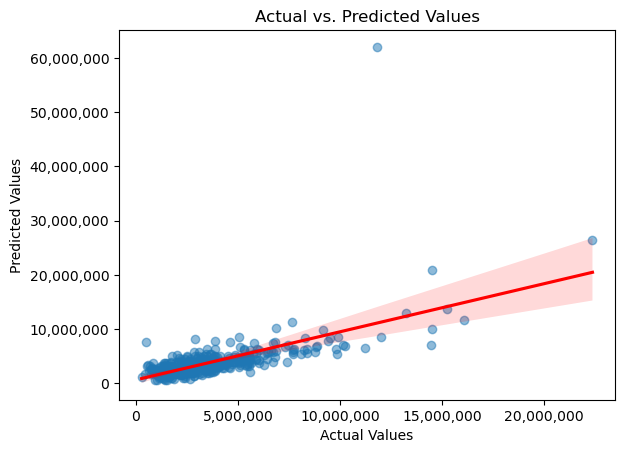

In [11]:
linear_model.fit(X_train_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_robust', bool(False), 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [12]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.588595e+06,2.938022e+06,1.089008e+06,1.253842e+06,0.670849,-0.207554,0.619289,0.050381,-2.871632e+12,1.776179e+11,-1.144394e+06,34997.042051,None


### 1.b. Linear Regression with PCA

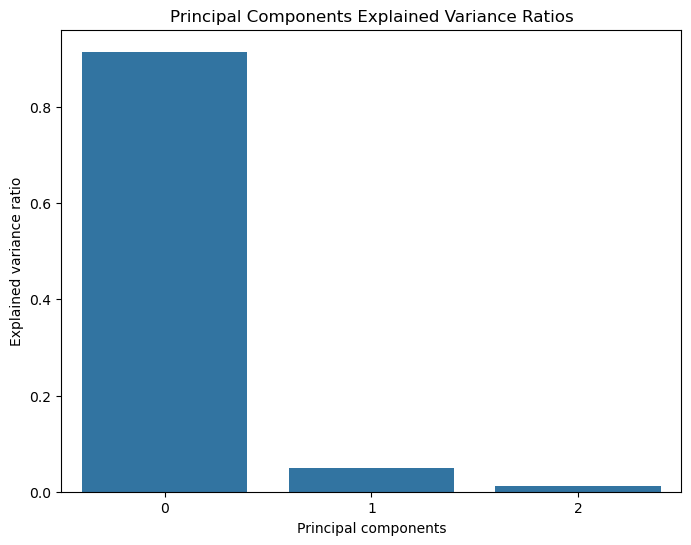

                                 PC 1      PC 2      PC 3
public_insurance_ratio       0.999915 -0.002457  0.000435
lep_patients_ratio           0.005495  0.010289  0.051059
diverse_race_proportion      0.004229 -0.000447 -0.023623
uninsured_ratio              0.003486 -0.006484 -0.021574
total_0_17_ratio             0.003116  0.002953  0.089383
fpl_100_below_ratio          0.002612  0.003242  0.016856
poverty_ratio                0.002612  0.003242  0.016856
total_other_revenue          0.002496  0.984321 -0.149994
total_grant_funding          0.001951  0.092255  0.374108
grants_to_rev_ratio          0.001475 -0.063930  0.031000
low_income_ratio             0.001465  0.000873  0.012967
other_revenue_category_Zero  0.001397 -0.008616 -0.014785
hispanic_proportion          0.001269  0.007896  0.061952
total_patients               0.001146  0.077763  0.399767
state_freq_enc               0.000616  0.002306  0.151730


In [13]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_rr)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rr)
X_test_pca = pca.transform(X_test_rr)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_rr.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [14]:
X_train_pca_df = pd.DataFrame(X_train_pca[:,0], 
                              columns=['PC 1'], 
                              index=X_train_rr.index)
X_train_pca_rr = pd.concat([X_train_rr, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca[:,0], 
                              columns=['PC 1'], 
                              index=X_test_rr.index)

X_test_pca_rr = pd.concat([X_test_rr, X_test_pca_df], axis=1)

R2 Score: -0.20514599763598218, Root Mean Squared Error: 2935091.4650314203, Mean Absolute Error: 1253803.0397022332


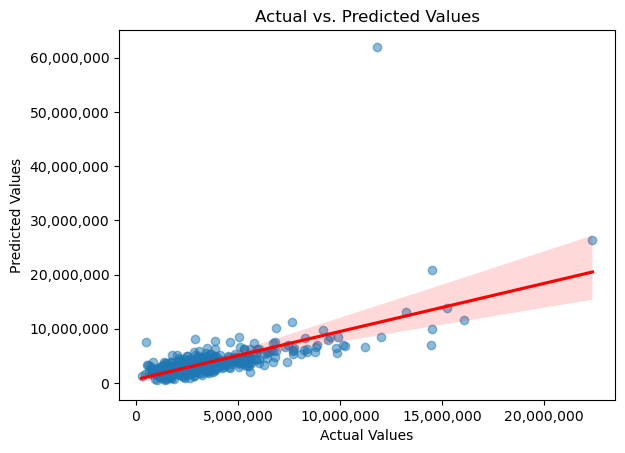

In [15]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [16]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.588595e+06,2.938022e+06,1.089008e+06,1.253842e+06,0.670849,-0.207554,0.619289,0.050381,-2.871632e+12,1.776179e+11,-1.144394e+06,34997.042051,None
1,Linear Regression,reduced_robust,True,1.588597e+06,2.935091e+06,1.089100e+06,1.253803e+06,0.670848,-0.205146,0.619289,0.050381,-2.871632e+12,1.776179e+11,-1.144394e+06,34997.042051,None


### 1.c. Rounded

R2 Score: -0.20446267406742002, Root Mean Squared Error: 2933947.59503969, Mean Absolute Error: 1253893.235571587


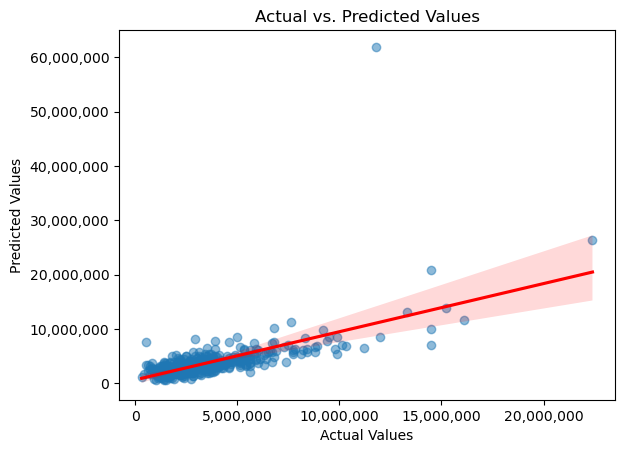

In [17]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_rr, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## 2. Reduced & Power Transformed Data

### 2.a. Linear Regression

In [18]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.569593783357331, 0.024638954318349324),
 'neg_mean_squared_error': (-3276519526356.2715, 241349115077.8303),
 'neg_mean_absolute_error': (-1275754.144530016, 51012.66571377516)}

R2 Score: 0.6125427593438423, Root Mean Squared Error: 1664231.3499044818, Mean Absolute Error: 1225130.6077727182


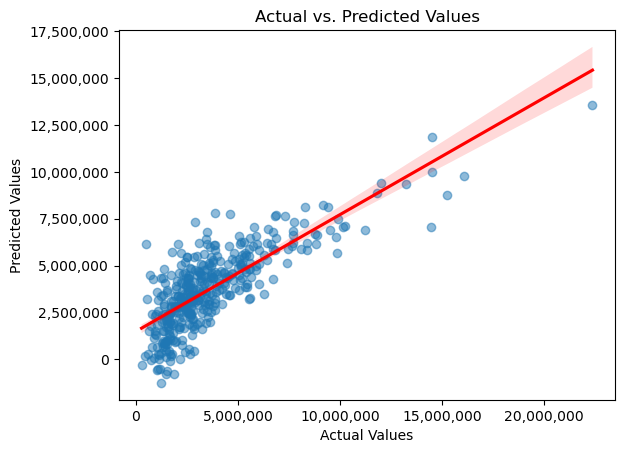

In [19]:
linear_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 2.b. Linear Regression with PCA

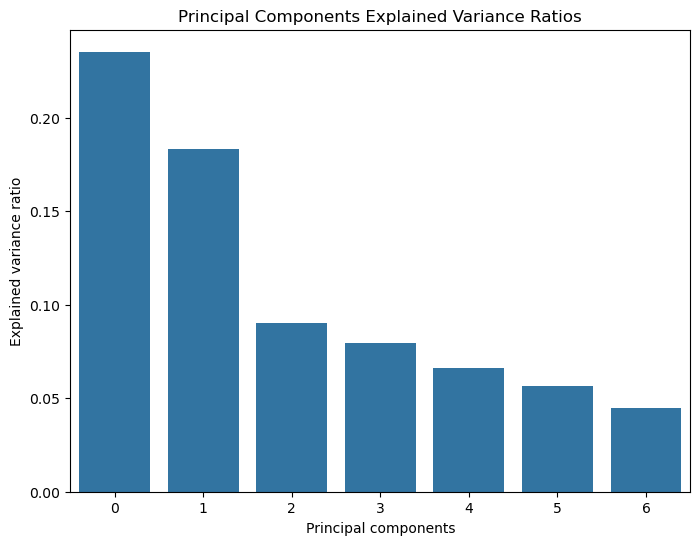

                                           PC 1      PC 2      PC 3      PC 4  \
private_insurance_ratio                0.237472  0.279184  0.021147  0.009463   
medicare_18_up_ratio                   0.234160  0.214280  0.259878 -0.064046   
total_18_up_ratio                      0.204062 -0.109973  0.430370  0.270914   
grants_to_rev_ratio                    0.052584 -0.093603 -0.019820 -0.219936   
other_revenue_category_Less than 100K  0.044338 -0.024536 -0.016426 -0.016676   
other_revenue_category_Zero            0.031397 -0.049634  0.003553 -0.062037   
other_revenue_category_Over 30M       -0.000713  0.000152  0.000507  0.002171   
FundingCHC                            -0.001339  0.041125 -0.043579 -0.011725   
other_revenue_category_500K to 1M     -0.014652  0.018026 -0.005510  0.029111   
FundingPH                             -0.015078 -0.000637  0.005526 -0.001639   
fin_confidential                      -0.015878  0.019502  0.006065 -0.000417   
ops_confidential            

In [20]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_rp)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rp)
X_test_pca = pca.transform(X_test_rp)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_rp.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [21]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_rp.index)

X_train_pca_rp = pd.concat([X_train_rp, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_rp.index)

X_test_pca_rp = pd.concat([X_test_rp, X_test_pca_df], axis=1)

R2 Score: 0.6123893802116189, Root Mean Squared Error: 1664560.7192861706, Mean Absolute Error: 1229050.0074441687


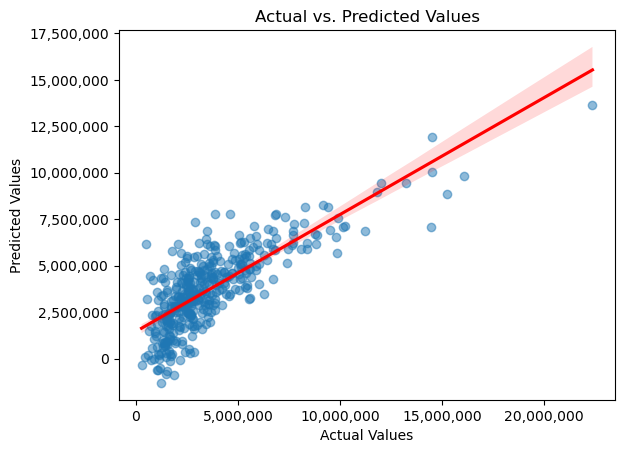

In [22]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rp, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 2.c. Rounded

In [23]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores



{'r2': (0.5693271248013724, 0.024507173224308534),
 'neg_mean_squared_error': (-3279261470032.423, 240868023036.00507),
 'neg_mean_absolute_error': (-1276324.4309612878, 51343.42474737039)}

R2 Score: 0.6127798384009373, Root Mean Squared Error: 1663545.4100837188, Mean Absolute Error: 1223270.2411893618


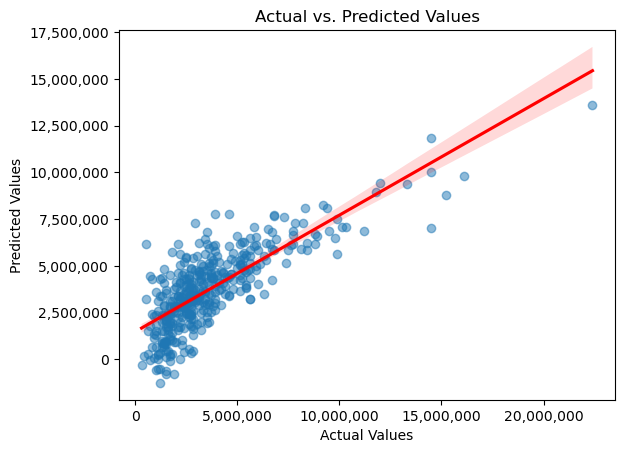

In [24]:
linear_model.fit(X_train_rp, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'reduced_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## 3. Imputed & Robust Scaled Data

### 3.a. Linear Regression

In [25]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6202262311478232, 0.05014037319985167),
 'neg_mean_squared_error': (-2864640273475.3203, 176976151575.53955),
 'neg_mean_absolute_error': (-1143673.4920655354, 31161.39684080512)}

R2 Score: -0.10461493119670506, Root Mean Squared Error: 2810006.1008266406, Mean Absolute Error: 1244483.0226955204


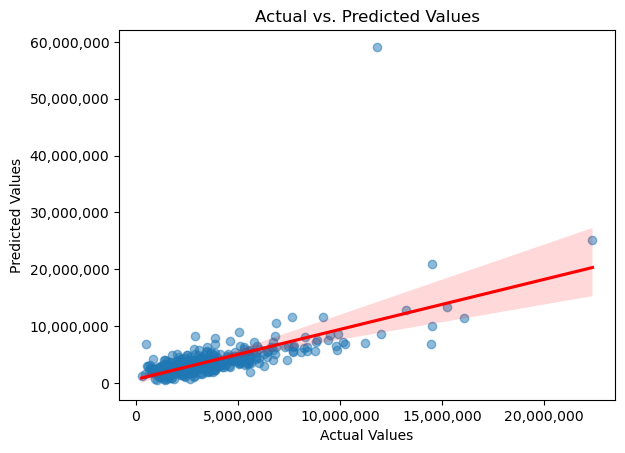

In [26]:
linear_model.fit(X_train_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 3.b. Linear Regression PCA

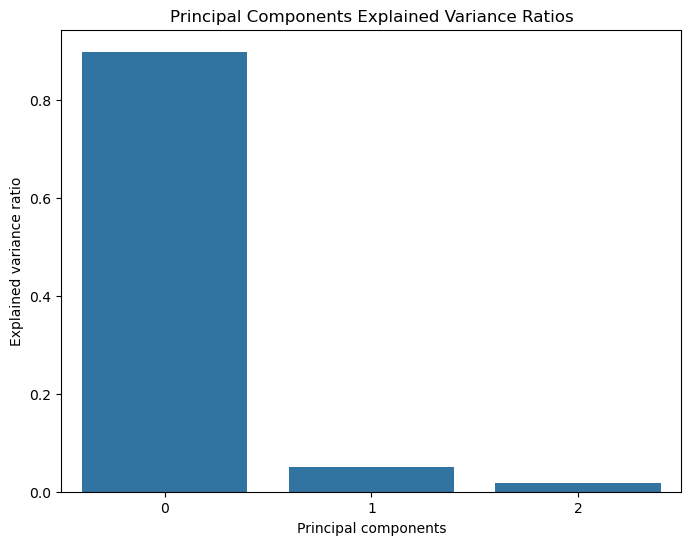

                                 PC 1      PC 2      PC 3
public_insurance_ratio       0.999903 -0.003449  0.002885
lep_patients_ratio           0.005501  0.014788 -0.059390
diverse_race_proportion      0.004227 -0.001943  0.020290
uninsured_ratio              0.003489 -0.005124 -0.007710
total_0_17_ratio             0.003120  0.006878 -0.063726
total_sfs                    0.002946  0.106928 -0.309423
fpl_100_below_ratio          0.002614  0.004298 -0.017013
poverty_ratio                0.002614  0.004298 -0.017013
total_other_revenue          0.002533  0.950622  0.295094
total_enabling_visits        0.002503  0.078936 -0.260966
enabling_patients            0.002354  0.064040 -0.239870
total_grant_funding          0.001974  0.110700 -0.288430
grants_to_rev_ratio          0.001474 -0.060450 -0.038155
low_income_ratio             0.001466  0.001877 -0.014953
other_revenue_category_Zero  0.001396 -0.009258  0.010581


In [27]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_ir)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ir)
X_test_pca = pca.transform(X_test_ir)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_ir.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [28]:
X_train_pca_df = pd.DataFrame(X_train_pca[:,0], 
                              columns=['PC 1'], 
                              index=X_train_ir.index)

X_train_pca_ir = pd.concat([X_train_ir, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca[:,0], 
                              columns=['PC 1'], 
                              index=X_test_ir.index)
X_test_pca_ir = pd.concat([X_test_ir, X_test_pca_df], axis=1)


R2 Score: -0.10464326185746198, Root Mean Squared Error: 2810042.1354740458, Mean Absolute Error: 1244491.6203473946


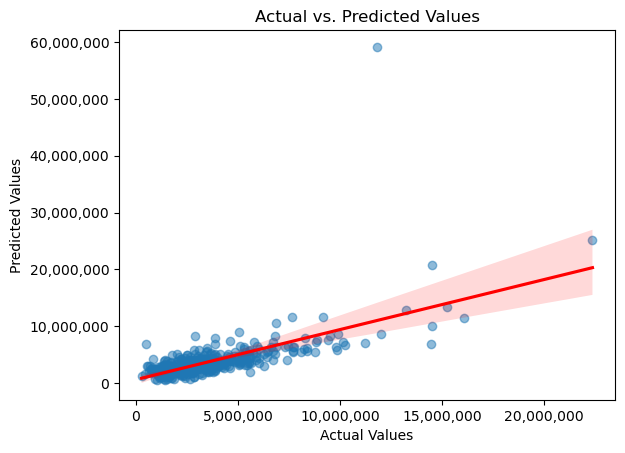

In [29]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ir, X_test_pca_ir, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'imputed_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 3.c. Rounded

R2 Score: -0.1027914361178699, Root Mean Squared Error: 2807387.5647204043, Mean Absolute Error: 1245405.3038053906


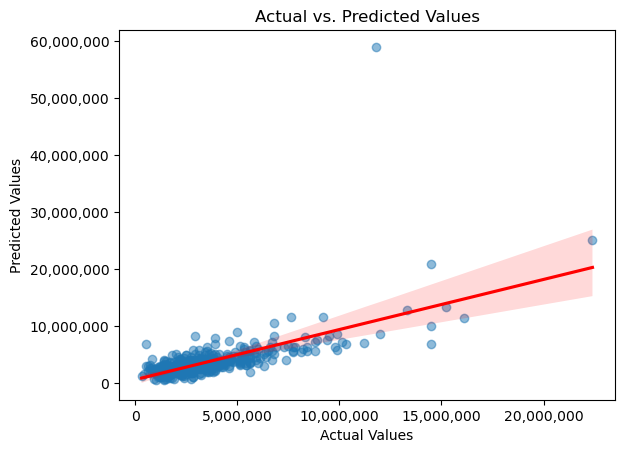

In [30]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ir, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## 4. Imputed & Power Transformed Data

### 4.a. Linear Regression

In [31]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.5742610438499647, 0.02281675502106882),
 'neg_mean_squared_error': (-3243658308507.9043, 263274367683.5537),
 'neg_mean_absolute_error': (-1274707.8891726937, 53346.895717794454)}

R2 Score: 0.622305164004278, Root Mean Squared Error: 1643131.5385256715, Mean Absolute Error: 1215499.7782735652


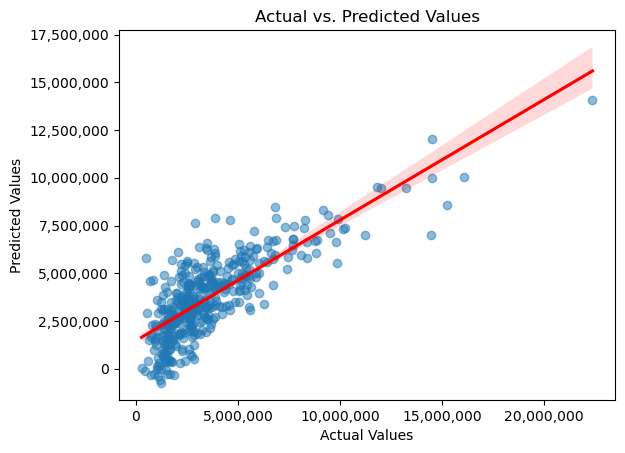

In [32]:
linear_model.fit(X_train_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 4.b. Linear Regression PCA

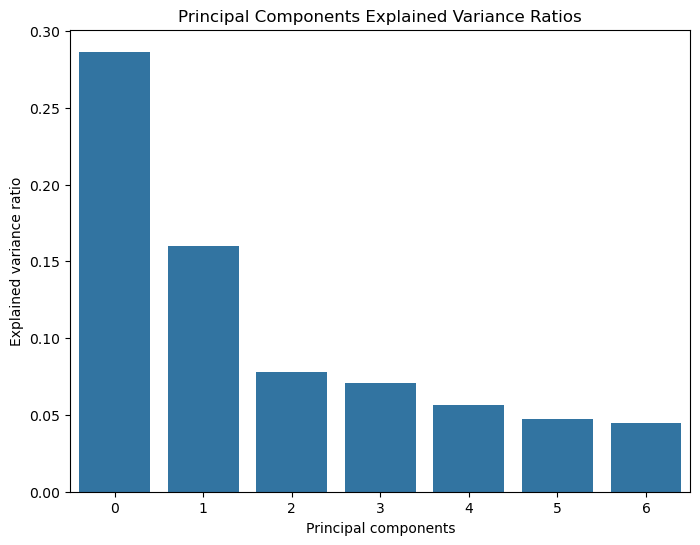

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_visits                 0.317379  0.126240 -0.024683 -0.043873  0.034369   
total_cost_care              0.312751  0.125191 -0.036275 -0.025656  0.113012   
total_patients               0.308002  0.131090  0.013243 -0.052692 -0.010680   
total_grant_funding          0.289128  0.037995 -0.045192  0.052381  0.055900   
TotalWeeklyHoursOfOperation  0.270285  0.156989 -0.095682 -0.159285 -0.148875   
total_sfs                    0.259573 -0.054563 -0.079280  0.223490 -0.096142   
total_sites                  0.255985  0.148632 -0.111008 -0.180689 -0.163516   
ZipCode_Count                0.251751  0.077955 -0.053673 -0.083509  0.050563   
enabling_patients            0.227671 -0.019319 -0.192967  0.104051 -0.058283   
total_enabling_visits        0.221234 -0.013423 -0.201788  0.095086 -0.041310   
hispanic_proportion          0.175384 -0.220196  0.072910  0.358658  0.007246   
lep_patients_ratio          

In [33]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_ip)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ip)
X_test_pca = pca.transform(X_test_ip)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_ip.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [34]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_ip.index)
X_train_pca_ip = pd.concat([X_train_ip, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_ip.index)

X_test_pca_ip = pd.concat([X_test_ip, X_test_pca_df], axis=1)



R2 Score: 0.6244322758001501, Root Mean Squared Error: 1638498.0897279698, Mean Absolute Error: 1208881.2977667493


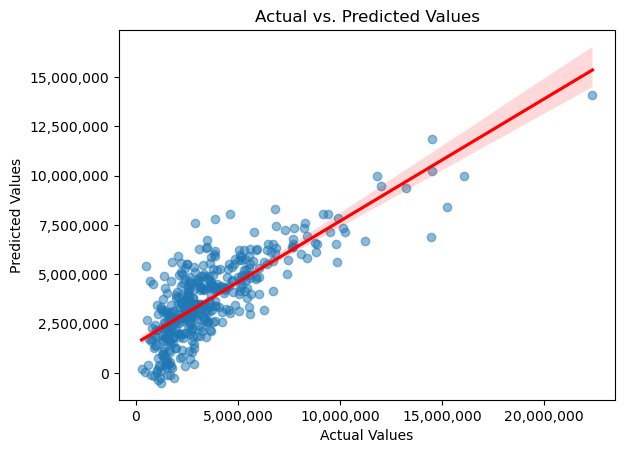

In [35]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ip, X_test_pca_ip, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

In [36]:
add_model_score('Linear Regression', 'imputed_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### 4.c. Rounded

R2 Score: 0.6225404739968687, Root Mean Squared Error: 1642445.1480268924, Mean Absolute Error: 1213404.1496407853


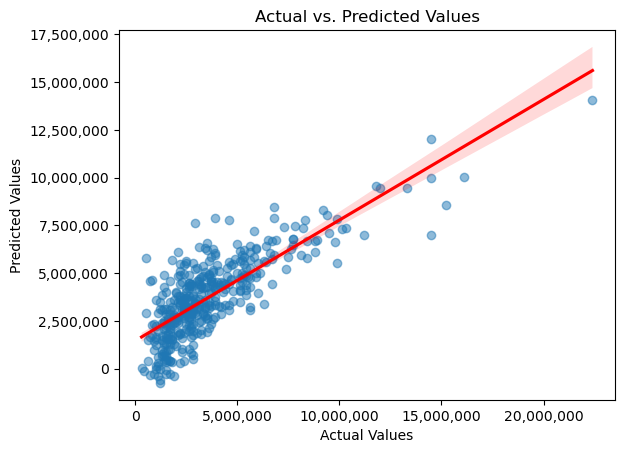

In [37]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ip, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

add_model_score('Linear Regression', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

# Scores Analysis

In [38]:
model_scores.sort_values('cv_mean_r2',ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
6,Linear Regression,imputed_robust,False,1.576343e+06,2.810006e+06,1.082088e+06,1.244483e+06,0.675906,-0.104615,0.620226,0.050140,-2.864640e+12,1.769762e+11,-1.143673e+06,31161.396841,None
7,Linear Regression,imputed_robust,True,1.576343e+06,2.810042e+06,1.082086e+06,1.244492e+06,0.675906,-0.104643,0.620226,0.050140,-2.864640e+12,1.769762e+11,-1.143673e+06,31161.396841,None
8,Linear Regression,imputed_robust_rounded,False,1.576346e+06,2.807388e+06,1.081835e+06,1.245405e+06,0.675947,-0.102791,0.620178,0.050113,-2.865861e+12,1.806949e+11,-1.143957e+06,32662.022465,None
0,Linear Regression,reduced_robust,False,1.588595e+06,2.938022e+06,1.089008e+06,1.253842e+06,0.670849,-0.207554,0.619289,0.050381,-2.871632e+12,1.776179e+11,-1.144394e+06,34997.042051,None
1,Linear Regression,reduced_robust,True,1.588597e+06,2.935091e+06,1.089100e+06,1.253803e+06,0.670848,-0.205146,0.619289,0.050381,-2.871632e+12,1.776179e+11,-1.144394e+06,34997.042051,None
2,Linear Regression,reduced_robust_rounded,False,1.588439e+06,2.933948e+06,1.089174e+06,1.253893e+06,0.670956,-0.204463,0.619287,0.050349,-2.872429e+12,1.799867e+11,-1.144797e+06,34743.122449,None
9,Linear Regression,imputed_power,False,1.687221e+06,1.643132e+06,1.194777e+06,1.215500e+06,0.628710,0.622305,0.574261,0.022817,-3.243658e+12,2.632744e+11,-1.274708e+06,53346.895718,None
10,Linear Regression,imputed_power,True,1.684698e+06,1.638498e+06,1.185976e+06,1.208881e+06,0.629819,0.624432,0.574261,0.022817,-3.243658e+12,2.632744e+11,-1.274708e+06,53346.895718,None
11,Linear Regression,imputed_power_rounded,False,1.687938e+06,1.642445e+06,1.195219e+06,1.213404e+06,0.628443,0.622540,0.573939,0.022664,-3.246766e+12,2.622630e+11,-1.275267e+06,53134.722175,None
3,Linear Regression,reduced_power,False,1.705168e+06,1.664231e+06,1.206401e+06,1.225131e+06,0.620769,0.612543,0.569594,0.024639,-3.276520e+12,2.413491e+11,-1.275754e+06,51012.665714,None


# Ensemble Models

## 5. Reduced & Robust Scaled Data

### 5.a. Random Forest Regression

In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rr, y_train)

y_pred = rf_gridsearch.predict(X_test_rr)
print(rf_gridsearch.score(X_test_rr, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6369761871155512
Best parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 20, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6395903794993407, Root Mean Squared Error: 1605092.2423334692, Mean Absolute Error: 1134153.0495037222


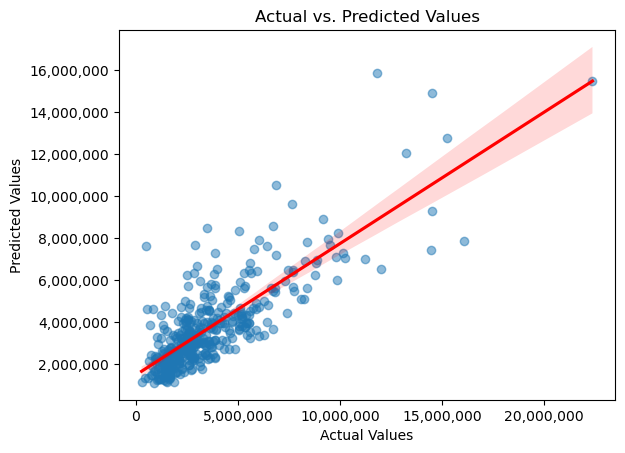

                             feature_importance
total_patients                         0.271160
TotalWeeklyHoursOfOperation            0.104243
total_grant_funding                    0.074066
uninsured_ratio                        0.043329
total_sites                            0.041834
ZipCode_Count                          0.040614
diverse_race_proportion                0.034004
medicaid_ratio                         0.029603
total_other_revenue                    0.028491
private_insurance_ratio                0.025250
grants_to_rev_ratio                    0.024724
hispanic_proportion                    0.024413
total_18_up_ratio                      0.023022
total_0_17_ratio                       0.022450
state_freq_enc                         0.022000


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_79495/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [40]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 5.b. RandomForestRegressor with PCA

R2 Score: 0.6387521201818165, Root Mean Squared Error: 1606957.7614689874, Mean Absolute Error: 1141991.0478163771


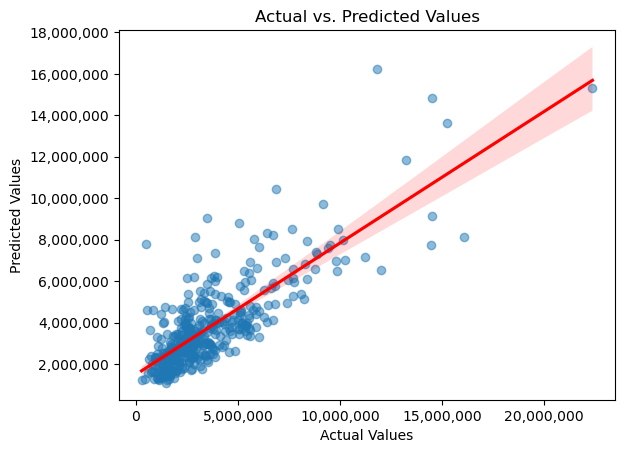

                             feature_importance
total_patients                         0.267688
TotalWeeklyHoursOfOperation            0.106818
total_grant_funding                    0.075141
uninsured_ratio                        0.044296
ZipCode_Count                          0.040066
total_sites                            0.035115
diverse_race_proportion                0.035067
medicaid_ratio                         0.028845
total_other_revenue                    0.025338
private_insurance_ratio                0.024853
grants_to_rev_ratio                    0.024292
PC 1                                   0.023743
hispanic_proportion                    0.022923
low_income_ratio                       0.022736
total_18_up_ratio                      0.022636


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_79495/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [41]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 5.c. Rounded

R2 Score: 0.6458233424857822, Root Mean Squared Error: 1590983.3949954866, Mean Absolute Error: 1117341.1910669976


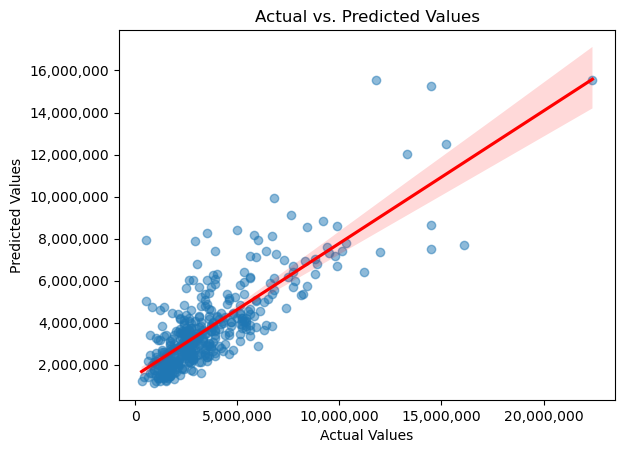

                             feature_importance
total_patients                         0.269930
TotalWeeklyHoursOfOperation            0.100400
total_grant_funding                    0.075710
ZipCode_Count                          0.043404
uninsured_ratio                        0.042493
total_sites                            0.039107
diverse_race_proportion                0.035791
medicaid_ratio                         0.029824
total_other_revenue                    0.028122
private_insurance_ratio                0.026587
grants_to_rev_ratio                    0.025143
hispanic_proportion                    0.023762
SiteCity_Count                         0.022694
low_income_ratio                       0.022638
total_0_17_ratio                       0.022610


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_79495/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [42]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## 6. Reduced & Power Transformed Data

### 6.a. Random Forest Regressor with GridSearch

In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rp, y_train)

y_pred = rf_gridsearch.predict(X_test_rp)
print(rf_gridsearch.score(X_test_rp, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.641251737451186
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 10, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6426308630662753, Root Mean Squared Error: 1598307.4721092223, Mean Absolute Error: 1123536.585032933


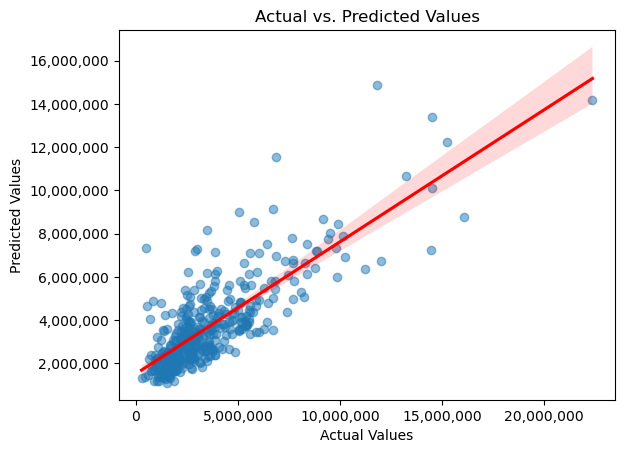

                             feature_importance
total_patients                         0.232008
TotalWeeklyHoursOfOperation            0.152314
total_grant_funding                    0.126966
total_sites                            0.082326
ZipCode_Count                          0.054376
total_other_revenue                    0.035691
SiteCity_Count                         0.032262
uninsured_ratio                        0.027946
diverse_race_proportion                0.023816
hispanic_proportion                    0.022496
medicaid_ratio                         0.018096
lep_patients_ratio                     0.017018
fpl_100_below_ratio                    0.016234
FundingMHC                             0.015147
grants_to_rev_ratio                    0.014776


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_79495/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [44]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 6.b. RandomForestRegressor with PCA

R2 Score: 0.6473973142824425, Root Mean Squared Error: 1587612.8891616708, Mean Absolute Error: 1103656.3716400724


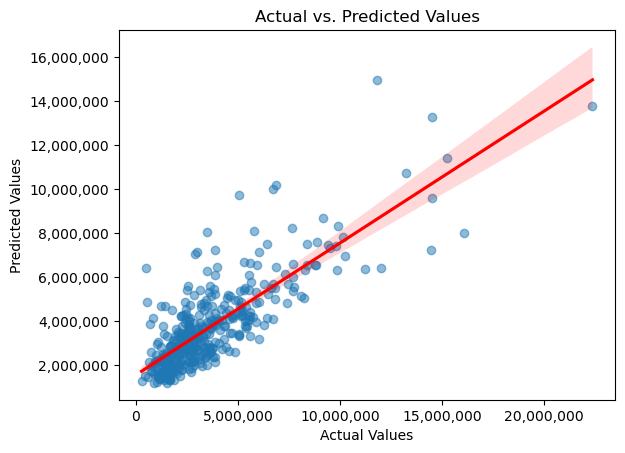

                             feature_importance
total_patients                         0.192514
TotalWeeklyHoursOfOperation            0.112227
total_grant_funding                    0.111661
PC 1                                   0.085188
total_sites                            0.076776
ZipCode_Count                          0.044193
SiteCity_Count                         0.035129
total_other_revenue                    0.027290
uninsured_ratio                        0.019984
hispanic_proportion                    0.018821
PC 4                                   0.017767
FundingMHC                             0.016418
PC 3                                   0.016271
PC 6                                   0.015304
PC 2                                   0.014128


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_79495/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [45]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 6.c. Rounded

R2 Score: 0.65748416137365, Root Mean Squared Error: 1564573.639847309, Mean Absolute Error: 1107348.3734286823


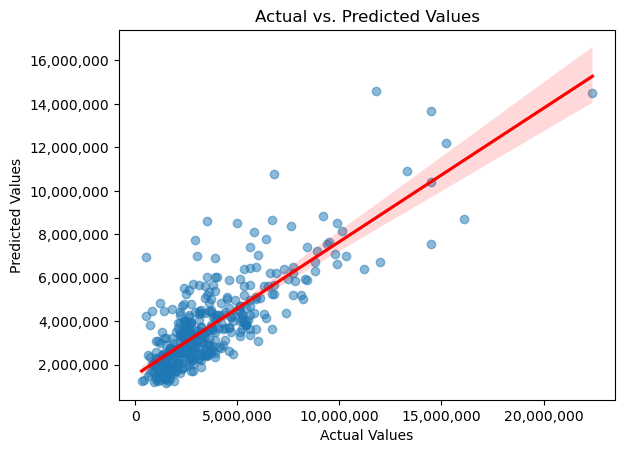

                             feature_importance
total_patients                         0.213262
TotalWeeklyHoursOfOperation            0.174380
total_grant_funding                    0.119885
total_sites                            0.086342
ZipCode_Count                          0.061803
uninsured_ratio                        0.029677
total_other_revenue                    0.027812
SiteCity_Count                         0.024057
diverse_race_proportion                0.022423
hispanic_proportion                    0.021112
medicaid_ratio                         0.018808
poverty_ratio                          0.016675
lep_patients_ratio                     0.016576
FundingMHC                             0.015543
low_income_ratio                       0.014804


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_79495/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [46]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power_rounded', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## 7. Imputed & Robust Scaled Data

### 7.a. Random Forest Regressor

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_ir, y_train)

y_pred = rf_gridsearch.predict(X_test_ir)
print(rf_gridsearch.score(X_test_ir, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6439704999944635
Best parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1}


R2 Score: 0.6409943964738145, Root Mean Squared Error: 1601962.781190428, Mean Absolute Error: 1119346.5298759306


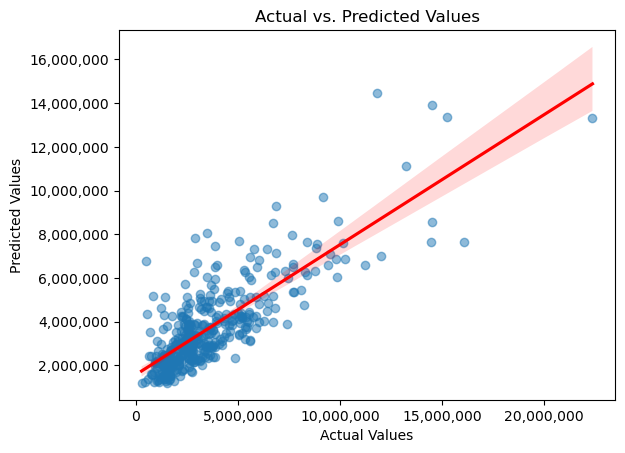

                             feature_importance
total_patients                         0.100321
total_cost_care                        0.083545
total_visits                           0.079090
TotalWeeklyHoursOfOperation            0.071446
total_grant_funding                    0.055484
total_sfs                              0.050651
total_sites                            0.046845
ZipCode_Count                          0.038884
uninsured_ratio                        0.030187
enabling_patients                      0.027218
SiteCity_Count                         0.026930
diverse_race_proportion                0.026911
medicaid_ratio                         0.025430
total_enabling_visits                  0.025188
total_other_revenue                    0.024198


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_79495/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [48]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 7.c. Rounded

R2 Score: 0.6414789887304981, Root Mean Squared Error: 1600711.2079566119, Mean Absolute Error: 1114627.7915632755


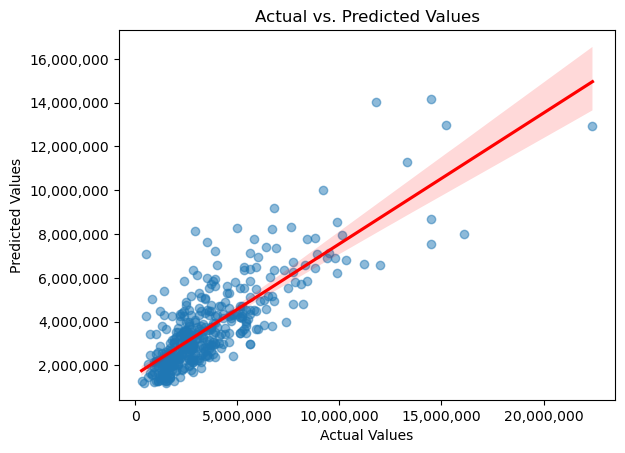

                             feature_importance
total_patients                         0.102552
total_visits                           0.083675
total_cost_care                        0.074777
TotalWeeklyHoursOfOperation            0.071488
total_grant_funding                    0.058013
total_sfs                              0.048717
total_sites                            0.042719
ZipCode_Count                          0.041750
uninsured_ratio                        0.030593
diverse_race_proportion                0.027080
SiteCity_Count                         0.026879
enabling_patients                      0.025637
total_other_revenue                    0.025552
medicaid_ratio                         0.024514
hispanic_proportion                    0.022992


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_79495/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [49]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## 8. Imputed & Power Transformed Data

### 8.a. Random Forest Regressor

In [50]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, scoring='r2', cv=kf)

rf_gridsearch.fit(X_train_ip, y_train)

y_pred = rf_gridsearch.predict(X_test_ip)
print(rf_gridsearch.score(X_test_ip, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6460631419260027
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'n_estimators': 50, 'n_jobs': -1}


R2 Score: 0.6141873338271777, Root Mean Squared Error: 1660695.6528324243, Mean Absolute Error: 1155967.09382134


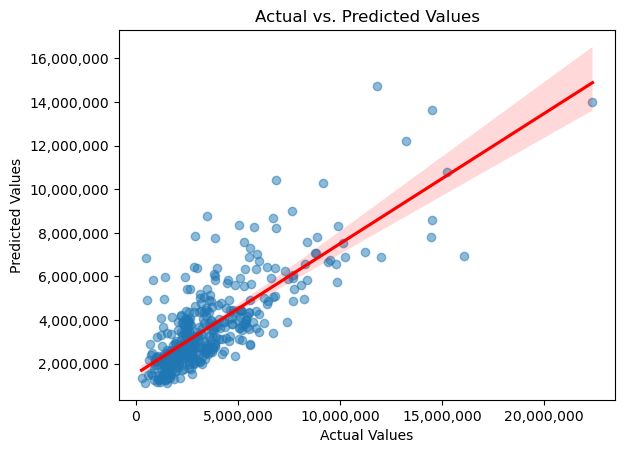

                             feature_importance
total_patients                         0.186973
total_visits                           0.104442
total_cost_care                        0.076565
TotalWeeklyHoursOfOperation            0.065451
total_grant_funding                    0.057757
total_sfs                              0.043413
total_sites                            0.040375
uninsured_ratio                        0.036335
ZipCode_Count                          0.034643
diverse_race_proportion                0.031747
medicaid_ratio                         0.021271
total_other_revenue                    0.019666
low_income_ratio                       0.018519
private_insurance_ratio                0.017954
total_0_17_ratio                       0.017885


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_79495/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [51]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ip, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train, y_test)

fig, ax = plt.subplots()
sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### 8.b. Rounded

R2 Score: 0.6280534109740923, Root Mean Squared Error: 1630406.7684995763, Mean Absolute Error: 1146900.7444168734


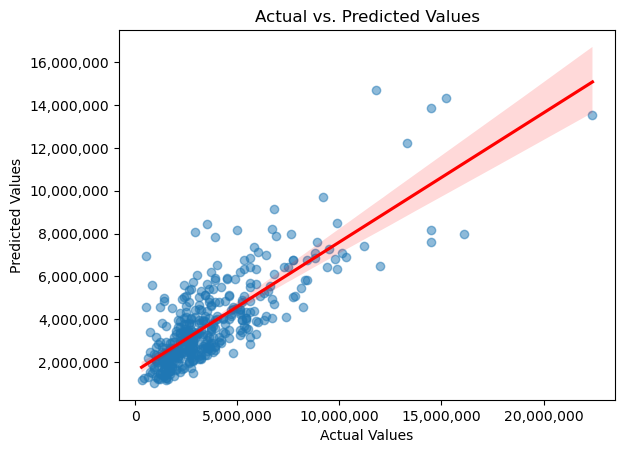

                             feature_importance
total_patients                         0.134016
total_visits                           0.110890
total_cost_care                        0.100752
TotalWeeklyHoursOfOperation            0.072404
total_sfs                              0.050112
total_grant_funding                    0.047604
total_sites                            0.041301
ZipCode_Count                          0.036305
uninsured_ratio                        0.031673
diverse_race_proportion                0.028474
medicaid_ratio                         0.024138
enabling_patients                      0.022521
total_enabling_visits                  0.020594
SiteCity_Count                         0.020430
total_other_revenue                    0.020106


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_79495/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [52]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ip, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

# Scoring Summary

In [53]:
pd.options.display.float_format = '{:.6f}'.format
model_scores.sort_values('score_mae_test', ascending=True)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
16,Random Forest Regressor,reduced_power,True,770030.094517,1587612.889162,549858.660802,1103656.371640,0.922663,0.647397,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
17,Random Forest Regressor,reduced_power_rounded,True,766301.502027,1564573.639847,554033.883369,1107348.373429,0.923421,0.657484,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
19,Random Forest Regressor,imputed_robust_rounded,False,631091.207793,1600711.207957,419639.243876,1114627.791563,0.948061,0.641479,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
14,Random Forest Regressor,reduced_robust_rounded,False,652556.176610,1590983.394995,422521.299255,1117341.191067,0.944467,0.645823,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
18,Random Forest Regressor,imputed_robust,False,631785.064508,1601962.781190,420676.946185,1119346.529876,0.947940,0.640994,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
15,Random Forest Regressor,reduced_power,False,761869.017423,1598307.472109,554253.974508,1123536.585033,0.924294,0.642631,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
12,Random Forest Regressor,reduced_robust,False,637608.775671,1605092.242333,419173.243099,1134153.049504,0.946975,0.639590,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
13,Random Forest Regressor,reduced_robust,True,633123.505865,1606957.761469,420506.014084,1141991.047816,0.947719,0.638752,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
21,Random Forest Regressor,imputed_power_rounded,False,829625.116463,1630406.768500,586798.722045,1146900.744417,0.910241,0.628053,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
20,Random Forest Regressor,imputed_power,False,853982.440911,1660695.652832,588348.946305,1155967.093821,0.904881,0.614187,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."


In [54]:
best_forest = model_scores[model_scores['model_type'] == 'Random Forest Regressor']\
                .sort_values('score_mae_test', ascending=True).head(2)
best_linreg = model_scores[model_scores['model_type'] == 'Linear Regression']\
                .sort_values('score_mae_test', ascending=True).head(2)

top_models = pd.concat([best_forest, best_linreg], ignore_index=True)
top_models

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Random Forest Regressor,reduced_power,True,770030.094517,1587612.889162,549858.660802,1103656.371640,0.922663,0.647397,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,Random Forest Regressor,reduced_power_rounded,True,766301.502027,1564573.639847,554033.883369,1107348.373429,0.923421,0.657484,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
2,Linear Regression,imputed_power,True,1684698.469251,1638498.089728,1185975.791267,1208881.297767,0.629819,0.624432,0.574261,0.022817,-3243658308507.904297,263274367683.553711,-1274707.889173,53346.895718,None
3,Linear Regression,imputed_power_rounded,False,1687937.540870,1642445.148027,1195219.443647,1213404.149641,0.628443,0.622540,0.573939,0.022664,-3246765522397.410156,262262973449.210358,-1275266.869126,53134.722175,None


In [55]:
# best_params for the first rf model
best_params_first_model = top_models.loc[0, 'best_params']
print(best_params_first_model)

# best_params for the second rf model
best_params_second_model = top_models.loc[1, 'best_params']
print(best_params_second_model)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# Model Tuning

### **Reduced Robust Model with Rounded Target**

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 20, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [200, 300, 400], 
    'max_depth': [None, 20],
    'max_features': ['sqrt', 15, 20, 'log2'], 
    'min_samples_split': [2, 3, 5], 
    'min_samples_leaf': [1, 2, 4],  
    'criterion': ['absolute_error', 'friedman_mse', 'squared_error'], 
    'bootstrap': [True],  
    'n_jobs': [-1], 
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_rr, y_train_rounded)

y_pred = forest_gs.predict(X_test_rr)
print(forest_gs.score(X_test_rr, y_test_rounded))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.643041712586104
Best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1}


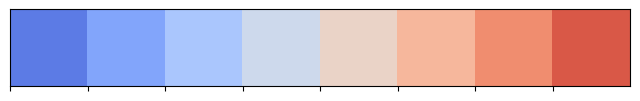

In [57]:
custom_palette = sns.color_palette('coolwarm', 8)
sns.set_palette(custom_palette)

custom_colors_binary = [custom_palette[0], custom_palette[6]]

sns.palplot(custom_palette)
plt.show()

R2 Score: 0.643715498456911, Root Mean Squared Error: 1595710.6546917346, Mean Absolute Error: 1105615.7896648895


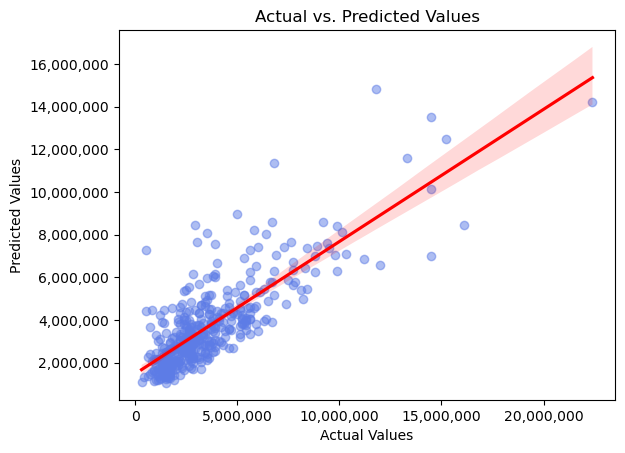

                             feature_importance
total_patients                         0.440463
TotalWeeklyHoursOfOperation            0.143145
total_grant_funding                    0.092449
total_sites                            0.042633
uninsured_ratio                        0.035999
diverse_race_proportion                0.023185
total_other_revenue                    0.019929
ZipCode_Count                          0.019306
SiteCity_Count                         0.017533
FundingMHC                             0.015360
medicaid_ratio                         0.013808
hispanic_proportion                    0.012564
private_insurance_ratio                0.012488
fpl_100_below_ratio                    0.011094
grants_to_rev_ratio                    0.010168
state_freq_enc                         0.009555
FundingHO                              0.009547
medicare_18_up_ratio                   0.009391
poverty_ratio                          0.009218
total_18_up_ratio                      0

In [58]:
rf_model_1 = RandomForestRegressor(**best_params, random_state=33)

rf_model_1.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model_1, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

fig, ax = plt.subplots()
sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.show()

rf_important_features = pd.DataFrame(rf_model_1.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(20))

In [59]:
y_pred_train = rf_model_1.predict(X_train_rr)

In [60]:
residuals = y_test - y_pred

# Create a DataFrame to analyze the residuals
results_df = pd.DataFrame({
    'Actual': y_test_rounded.flatten(), 
    'Predicted': y_pred.flatten(),
    'Residuals': residuals.flatten(),
    'Absolute_Residuals': abs(residuals).flatten()
})

# Sort the df by absolute residuals in descending order
results_df = results_df.sort_values(by='Absolute_Residuals', ascending=False)

results_df[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,403.00
mean,1105631.38
std,1149947.67
min,631.14
25%,327407.35
50%,797874.99
75%,1466611.32
max,8153076.15


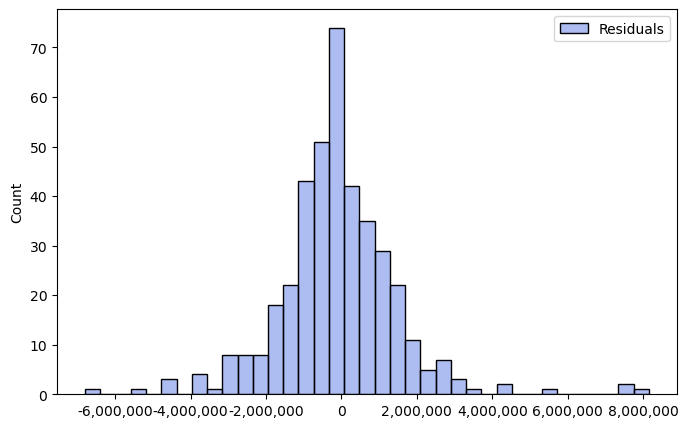

In [61]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(results_df[['Residuals']])
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 


In [64]:
results_df.sort_values('Absolute_Residuals', ascending=False)

,Actual,Predicted,Residuals,Absolute_Residuals
373,22400000,14229272.849373,8153076.150627,8153076.150627
346,16100000,8467454.549209,7629811.450791,7629811.450791
18,14500000,6995221.572178,7455320.427822,7455320.427822
124,500000,7284926.506827,-6797426.506827,6797426.506827
227,2900000,8454787.497429,-5536144.497429,5536144.497429
...,...,...,...,...
101,4300000,4312603.862804,18461.137196,18461.137196
388,3500000,3513022.799423,-10896.799423,10896.799423
336,3100000,3082648.249667,-8340.249667,8340.249667
308,2500000,2549144.228688,-4134.228688,4134.228688


In [65]:
residuals_train = y_train_rounded - y_pred_train

# Create a DataFrame to analyze the residuals
results_df_train = pd.DataFrame({
    'Actual': y_train_rounded.flatten(), 
    'Predicted': y_pred_train.flatten(),
    'Residuals': residuals_train.flatten(),
    'Absolute_Residuals': abs(residuals_train).flatten()
})

# Sort the df by absolute residuals in descending order
results_df_train = results_df_train.sort_values(by='Absolute_Residuals', ascending=False)

Text(0.5, 1.0, 'Train Prediction Residuals')

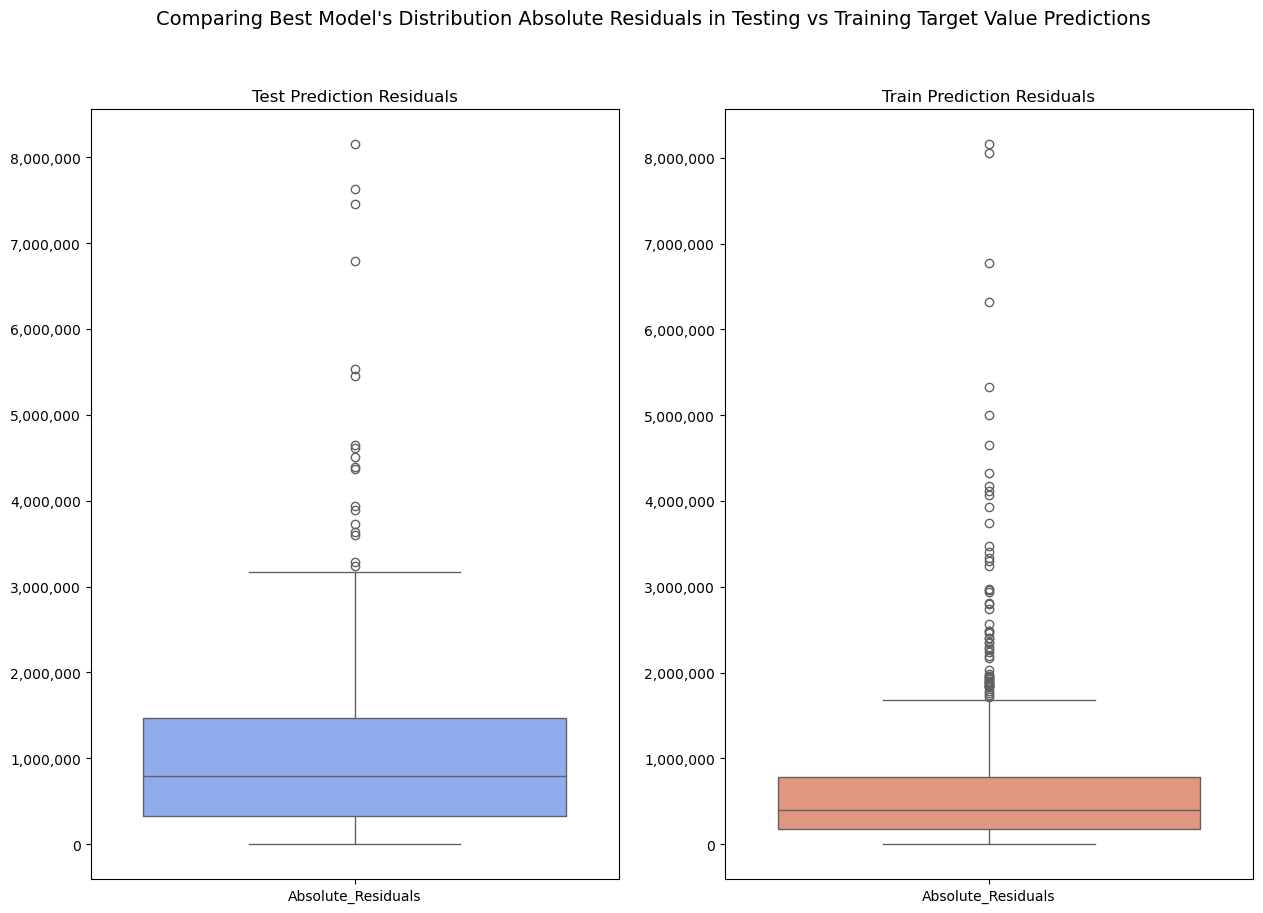

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

fig.suptitle("Comparing Best Model's Distribution Absolute Residuals in Testing vs Training Target Value Predictions", fontsize=14)

sns.boxplot(results_df[['Absolute_Residuals']], ax=ax[0], color=custom_palette[1])
ax[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax[0].set_title('Test Prediction Residuals')

sns.boxplot(results_df_train[['Absolute_Residuals']], ax=ax[1], color=custom_palette[6])
ax[1].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
ax[1].set_title('Train Prediction Residuals')


In [67]:
combined_data_test = pd.merge(X_test_rr, results_df, left_index=True, right_index=True, how='inner')

combined_data_train = pd.merge(X_train_rr, results_df_train, left_index=True, right_index=True, how='inner')
combined_data = pd.concat([combined_data_train, combined_data_test], axis=0)

In [68]:
df = pd.read_csv(DATA_PATH +'modeling/data_new_features.csv')
df.shape

(1342, 56)

In [69]:
combined_data = pd.merge(combined_data_test, df[['HealthCenterName', 'HealthCenterState']], left_index=True, right_index=True, how='inner')


In [70]:
combined_data_test.head(2)

,total_other_revenue,total_patients,ZipCode_Count,SiteCity_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,diverse_race_proportion,hispanic_proportion,poverty_ratio,...,UrbanRuralFlag_Urban,other_revenue_category_1M to 30M,other_revenue_category_500K to 1M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero,Actual,Predicted,Residuals,Absolute_Residuals
0,2.685290,0.675504,0.077670,0.250000,0.537888,0.505160,-1.102507,0.265271,-0.325806,0.033486,...,1,1,0,0,0,0,4700000,3943072.514332,781243.485668,781243.485668
1,0.394290,0.542112,0.330097,0.750000,0.849689,-0.060278,-0.299488,0.246761,-0.221809,-1.082839,...,0,0,0,0,0,0,3700000,3822755.036630,-138271.036630,138271.036630


In [71]:
combined_data_test[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,403.00
mean,1105631.38
std,1149947.67
min,631.14
25%,327407.35
50%,797874.99
75%,1466611.32
max,8153076.15


In [72]:
combined_data.groupby('HealthCenterState')[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

Absolute_Residuals                                     \
                               count        mean         std        min   
HealthCenterState                                                         
AL                              5.00   453075.33   236342.53   39794.20   
CT                             16.00  1087994.80   552644.99  200662.25   
DC                              8.00   804232.20   612195.60   59010.10   
DE                              3.00   820020.96   377408.66  402773.94   
FL                             26.00  1555310.80  1285477.49   56063.98   
GA                             11.00  1561362.81  2322707.61   83304.49   
KY                              7.00   719331.70   393614.07   38502.39   
MA                             37.00   926673.36   918705.50   33377.17   
MD                             17.00   793690.21   880730.62    4134.23   
ME                             18.00  1030705.33   870085.49  138271.04   
MS                             10.00   436362.21   482946.56   10896.80   
NC                              9.00   935820.56   538040.15  177781.58   
NH                              9.00  1118787.95   486874.68  407924.16   
NJ                             23.00   817358.64   880482.59   18461.14   
NY                             63.00  1224658.75  1365953.19   26406.38   
PA                             42.00  1084231.26   967028.73   36709.05   
RI                              8.00  1675853.57  2415772.98   93765.69   
SC                             10.00  1120818.45  1328699.48     631.14   
TN                             16.00  1623421.13  1801376.23  186305.39   
VA                             26.00  1166949.05  1119345.44   20714.30   
VT                             11.00  1442838.71  1148971.83  198045.04   
WV                             28.00   959795.77   711422.93   51910.44   

                                                                  
                         25%         50%         75%         max  
HealthCenterState                                                 
AL                 505305.96   530803.21   551583.68   637889.58  
CT                 713814.22  1152377.52  1454019.89  2417869.72  
DC                 281702.84   778499.91  1113484.29  1735636.05  
DE                 661243.64   919713.35  1028644.47  1137575.59  
FL                 684005.72  1014208.67  2363026.41  4504033.19  
GA                 512878.05   663796.07  1270040.57  8153076.15  
KY                 580329.71   728455.06   915551.85  1276601.31  
MA                 257878.68   638661.30  1414667.36  3897299.30  
MD                 148315.00   532479.42   910116.97  2708423.63  
ME                 361060.15   894583.38  1275666.81  2956797.41  
MS                  79990.55   190864.13   734250.11  1251867.27  
NC                 583314.55   817177.67  1305789.80  1818177.87  
NH                 802347.50  1214600.66  1301754.08  1848232.80  
NJ                 235091.75   399078.90   934343.90  3048723.51  
NY                 262653.36   789455.69  1371775.72  6797426.51  
PA                 450869.90   851614.25  1562918.26  5536144.50  
RI                 349343.57  1033954.58  1470244.76  7455320.43  
SC                 226774.96   722971.69  1503671.60  4396439.56  
TN                 719997.28  1007254.03  1872835.86  7629811.45  
VA                 296688.12   844549.56  1655931.03  3942800.91  
VT                 462354.38  1408922.34  1971185.76  3727146.21  
WV                 489788.79   765909.67  1379122.48  2481822.80

In [73]:
# Display cases with the largest absolute residuals
high_residuals = combined_data_test.sort_values(by='Absolute_Residuals', ascending=False).head(20)
high_residuals[['Actual', 'Predicted', 'Residuals', 'Absolute_Residuals', 'total_patients', 'UrbanRuralFlag_Urban']]

,Actual,Predicted,Residuals,Absolute_Residuals,total_patients,UrbanRuralFlag_Urban
373,22400000,14229272.849373,8153076.150627,8153076.150627,11.121094,1
346,16100000,8467454.549209,7629811.450791,7629811.450791,3.864055,1
18,14500000,6995221.572178,7455320.427822,7455320.427822,2.772124,1
124,500000,7284926.506827,-6797426.506827,6797426.506827,3.673368,1
227,2900000,8454787.497429,-5536144.497429,5536144.497429,4.091416,1
125,12000000,6564955.266955,5454745.733045,5454745.733045,0.947542,1
159,3000000,7653217.574093,-4647280.574093,4647280.574093,1.553281,1
176,3500000,8088425.854701,-4609949.854701,4609949.854701,1.879667,1
356,6800000,11346580.185093,-4504033.185093,4504033.185093,5.692663,1
369,14500000,10124895.444139,4396439.555861,4396439.555861,2.655031,1


# Results

The model called rf_model_1 performed the best in terms of R2 score. This model was trained and tested with the Reduced Power train/test split that also included PCA features in the dataset. 

Here were the results:

R2 Score: 0.6621142211476213, Root Mean Squared Error: 1752659.3727011054, Mean Absolute Error: 1139253.093420398

The linear regression models and random forest regressors performed better using the reduced dataset, which columns containing a lot of values were removed instead of imputed.